# Align Experiment and Colloidal Ice object

In this script, I will align the first experimental video with a Cairo lattice.

In [1]:
import os
import glob
import sys
import copy as cp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pims as pm
from pims import pipeline

sys.path.insert(0, '../icenumerics')
import icenumerics as ice
ureg = ice.ureg
import transformations as tr

sys.path.insert(0, '../Scripts/')
import support as sup
from importlib import reload  
reload(sup)

os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

%load_ext autoreload
%autoreload 2

In [2]:
directory =  "/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid"

In [3]:
filenames = [file for file in glob.glob(
    os.path.join(directory,('*.avi')))]

filenames = [f for f in filenames]
filenames

['/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp6_2022_03_29_14_00_27.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp7_2022_03_29_14_14_13.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp2_2022_03_29_13_04_12.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp3_2022_03_29_13_17_37.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp1_2022_03_29_12_49_39.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp8_2022_03_29_14_27_00.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid/Sample5_h3_w2_Exp4_2022_03_29_13_29_38.avi',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattic

## Collection of functions used to align 

In [4]:
def particle_locations_to_colloids(entry):
    
    nx = 4
    ny = 4
    a = 19.5458*ureg.um
    
    particle = ice.particle(radius = 5*ureg.um)

    trap_long = ice.trap(trap_sep = 10*ureg.um,
                   height = 30*ureg.pN*ureg.nm,
                   stiffness = 0.1*ureg.fN/ureg.nm)

    trap_short = ice.trap(trap_sep = 4.5258*ureg.um,
                   height = 30*ureg.pN*ureg.nm,
                  stiffness = 0.1*ureg.fN/ureg.nm)
    
    traps = []

    sp_cairo = sup.spins()
    v = ice.vertices()
    
    display(entry)
    
    sp_cairo.create_lattice(geometry = "cairo",size =[nx,ny],lattice_constant=a, border="periodic")
    
    for s in sp_cairo:
    
        if ( s.direction[0].magnitude == a.magnitude or s.direction[0].magnitude == -a.magnitude or 
            s.direction[1].magnitude == a.magnitude or s.direction[1].magnitude == -a.magnitude ):
        
            traps.append(trap_short)
        
        else:
        
            traps.append(trap_long)
            
    

    sp_cairo = tr.rotate(sp_cairo,(entry[["angle"]].values[0])*ureg.deg)
    sp_cairo = tr.scale(sp_cairo,entry[["scale"]].values*np.array([1,1]))
    sp_cairo = tr.translate(sp_cairo,entry[["x_offset","y_offset"]].values*ureg.um)
    
    col = ice.colloidal_ice(sp_cairo, particle, traps, height_spread = 0, susceptibility_spread = 0.1)
    
    return col

In [5]:
def strip_name(name,ext): 
    name = os.path.split(name)[-1]
    return name[:name.find(ext)]

### end collection of functions

In order to run de code we had to install pims and imageio-ffmpeg and add line:

    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

In [6]:
pd.DataFrame(data = [], columns = ["name","scale","x_offset", "y_offset", "angle"]).to_csv(os.path.join(directory,"parameters.dat"),sep="\t")
parameters = pd.read_csv(os.path.join(directory,"parameters.dat"),sep = "\t", index_col = [0])

/home/carolina/anaconda3/lib/python3.7/site-packages/pims/api.py:207: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
/home/carolina/anaconda3/lib/python3.7/site-packages/pims/api.py:207: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7f6ff0a33170>
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'


name        Sample5_h3_w2_Exp8_2022_03_29_14_27_00
scale                                          1.7
x_offset                                      -115
y_offset                                       437
angle                                            0
Name: Sample5_h3_w2_Exp8_2022_03_29_14_27_00, dtype: object

../Scripts/support.py:283: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY
/home/carolina/CairoLattice_ACI_PROJECT/Experiments/transformations.py:39: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  [0,0,1]])


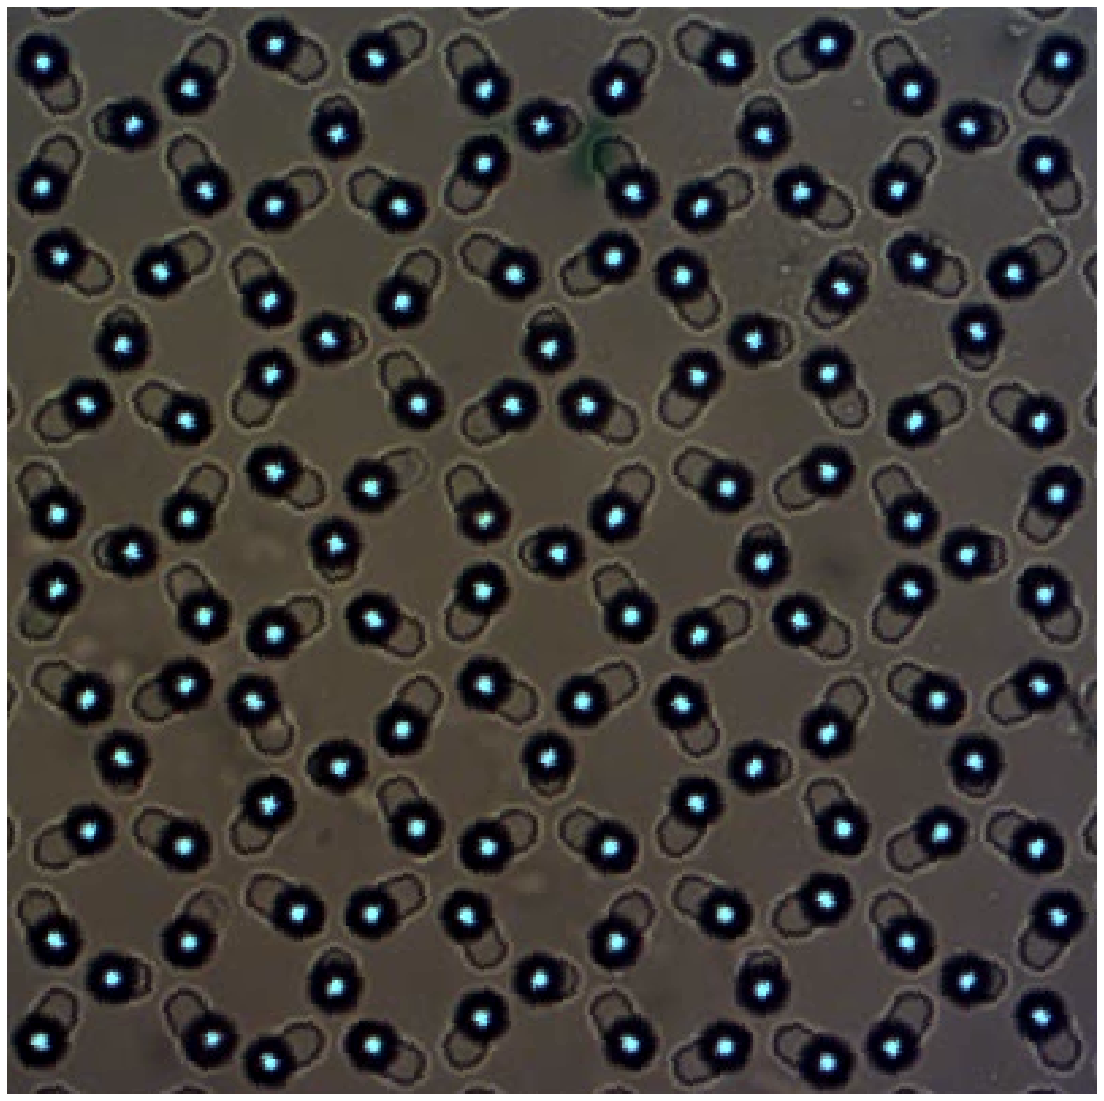

In [9]:
i = 5

fname = filenames[i]

basename = strip_name(fname,".avi")
parameters.loc[basename,"name"] = basename
parameters.loc[basename,"scale"] = 1.7
parameters.loc[basename,"x_offset"] = -115
parameters.loc[basename,"y_offset"] = 437
parameters.loc[basename,"angle"] = 0

fig, ax = plt.subplots(1,1,figsize=(20,20))

video = pm.open(fname)
col = particle_locations_to_colloids(parameters.loc[basename])

ax.imshow(video[0])
ax.axis('off')
#col.display(ax)
#ax.set_xlim(0, 320)
#ax.set_ylim(0, 320)
plt.savefig('cairo.pdf')

Aligned!

Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7fac7c6eed40>
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'


name        Sample5_h3_w2_Exp4_2022_03_29_13_29_38
scale                                          1.7
x_offset                                      -116
y_offset                                       435
angle                                            0
Name: Sample5_h3_w2_Exp4_2022_03_29_13_29_38, dtype: object

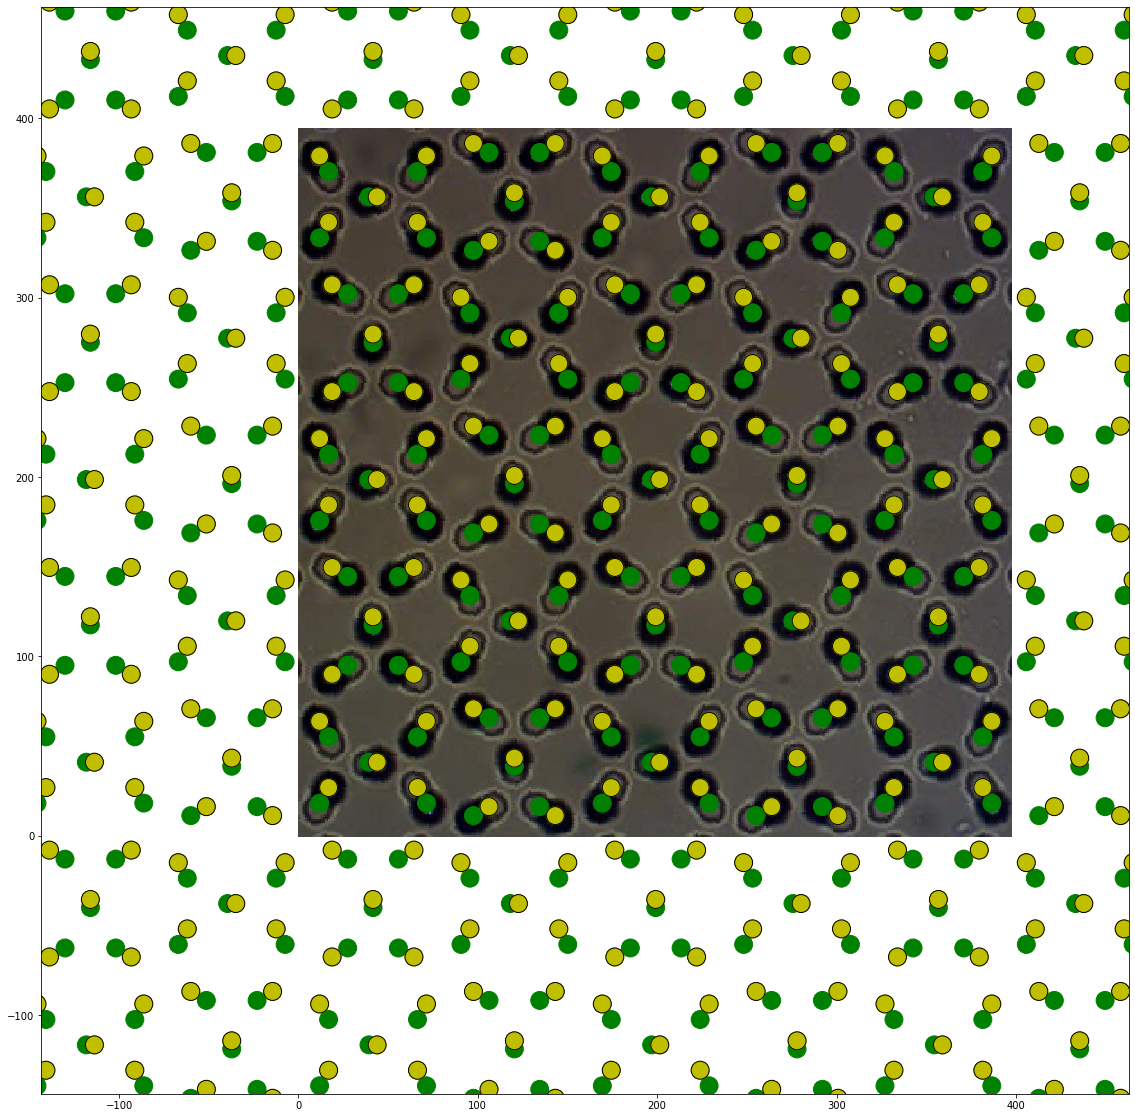

In [11]:
i = 3

fname = filenames[i]

basename = strip_name(fname,".avi")
parameters.loc[basename,"name"] = basename
parameters.loc[basename,"scale"] = 1.7
parameters.loc[basename,"x_offset"] = -116
parameters.loc[basename,"y_offset"] = 435
parameters.loc[basename,"angle"] = 0

fig, ax = plt.subplots(1,1,figsize=(20,20))

video = pm.open(fname)
col = particle_locations_to_colloids(parameters.loc[basename])

ax.imshow(video[0])
col.display(ax)
#ax.set_xlim(0, 320)
#ax.set_ylim(0, 320)

Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7fe2706cdd40>
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'


name        Sample5_h3_w2_Exp0_2022_03_29_12_35_31
scale                                          1.7
x_offset                                      -117
y_offset                                       435
angle                                            0
Name: Sample5_h3_w2_Exp0_2022_03_29_12_35_31, dtype: object

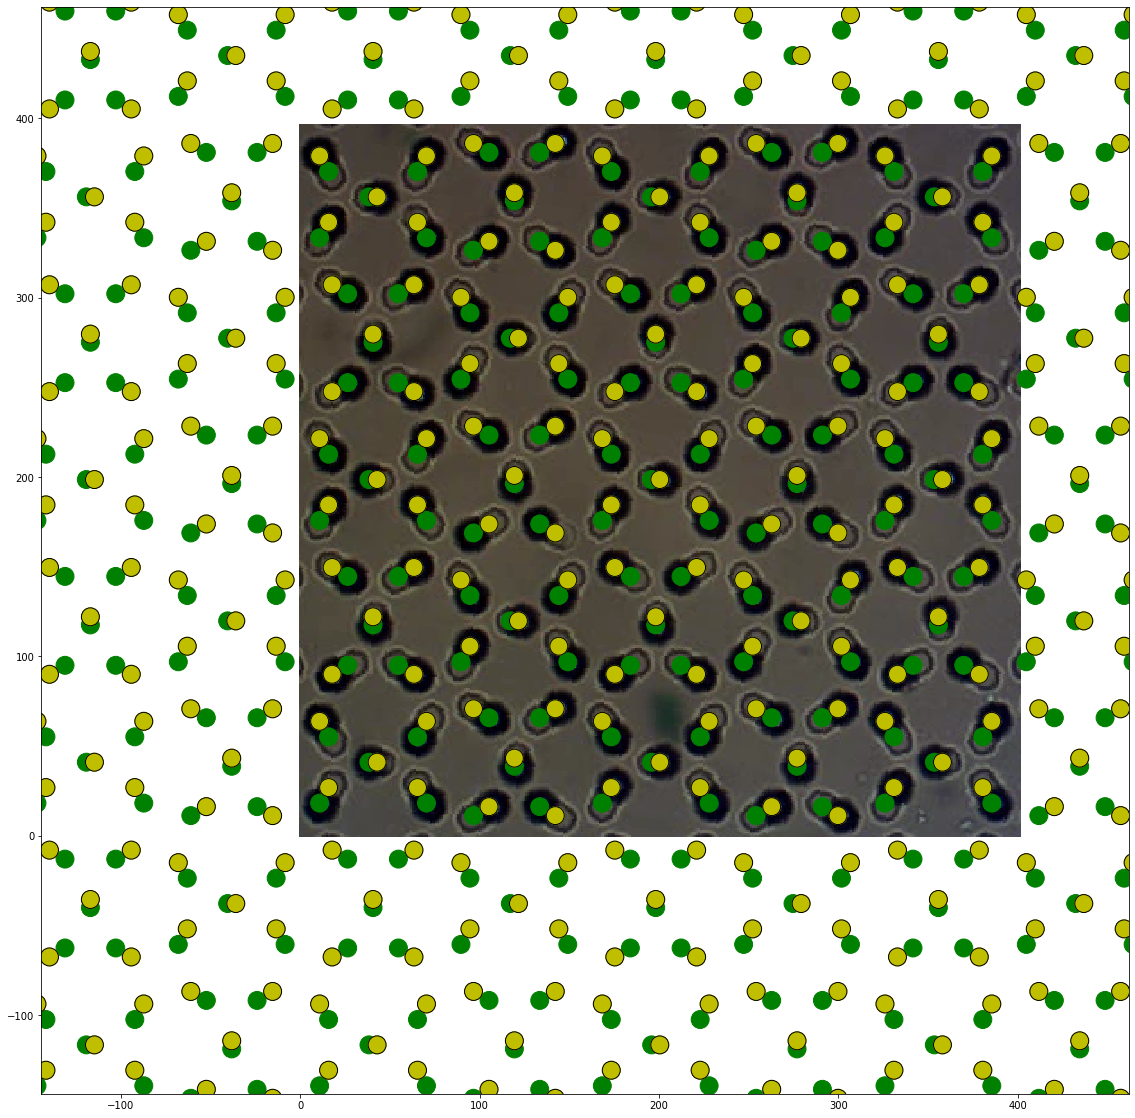

In [34]:
i = 2

fname = filenames[i]

basename = strip_name(fname,".avi")
parameters.loc[basename,"name"] = basename
parameters.loc[basename,"scale"] = 1.7
parameters.loc[basename,"x_offset"] = -117
parameters.loc[basename,"y_offset"] = 435
parameters.loc[basename,"angle"] = 0

fig, ax = plt.subplots(1,1,figsize=(20,20))

video = pm.open(fname)
col = particle_locations_to_colloids(parameters.loc[basename])

ax.imshow(video[0])
col.display(ax)
#ax.set_xlim(0, 320)
#ax.set_ylim(0, 320)